# Evaluating ECLand Emulator on ISMN data

In adjusting the flags, we can choose the network, station, soil variable and layer for evaluation. Here we run this example with soil temperature.

In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from data_module import *
from evaluation_module import *
from forecast_module import *
from observation_module import *
from visualisation_module import *

from helpers import *
from tests.test_model import *


set_global_seed(42)

SCRIPT_DIR = os.getcwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))
print(SCRIPT_DIR) 

path_to_plots = '../plots/'
path_to_results = '../results/'

#EX_CONFIG = load_config(config_path = '../../configs/smosmania_st.yaml')
EX_CONFIG = load_config(config_path = '../../configs/tereno_st.yaml')

network =  EX_CONFIG['network'] #'soil_TERENO_ISMN_2022.nc'#'soil_SMOSMANIA_ISMN_2022.nc' # 'soil_TERENO_ISMN_2022.nc'
network_name = network.split('_')[1]
station = EX_CONFIG['station'] # 'Lahas'
variable = EX_CONFIG['variable'] 
depth = EX_CONFIG['depth']  # [0.05, 0.2, 0.3]

years = EX_CONFIG['years']
models = EX_CONFIG['models']# , 'xgb'

maximum_leadtime = EX_CONFIG['maximum_leadtime'] # medium range, ten days
tolerance = EX_CONFIG['tolerance']
score = EX_CONFIG['score']

print("Network: ", network)
print("Station: ", station)
print("Variable: ", variable)
print("Depth: ", depth)
print("Years: ", years)
print("Models: ", models)
print("Initial time: ", EX_CONFIG['initial_time'])

/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator
cpu
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/notebooks
Opening ../../configs/tereno_st.yaml for experiment configuration.
Network:  soil_TERENO_ISMN_2022.nc
Station:  Gevenich
Variable:  st
Depth:  [0.05, 0.2, 0.5]
Years:  [2021, 2022]
Models:  ['mlp', 'lstm', 'xgb']
Initial time:  2022-02-01T00:00:00


/perm/pamw/venvs/myevalenv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


To explore station data and ECLand forecasts, we load the untransformed data and plot it. ECLand slightly overestimates initial soil conditions in January, but most notably is the larger variance compared to the measurements in the first layer. From the dataset we loaded, we select the same global mean and standard deviation from the synthetic data to also z-score the station data. Then we explore their overlay. 
After, we create a hybrid data set with the z-scored station data for soil temperature, that we use for the prognostic initialsation - instead of the ECLand simulations as before. Then we initialise the model with the hybrid data and run the forecast

In [2]:
Gevenich = ObservationModule(network = network, 
                             station = station,
                             variable = variable,
                             depth=depth) # Initialise the Observation Module with the default Station (Gevenich)

Gevenich.load_station(years = years) # Load two years of station data for lookback slicing
Gevenich.load_forcing() # Load forcing for matching data base with station data
closest_grid_cell = Gevenich.match_station_with_forcing() # Match the station with clostest grid cell and extract the index of the grid cell
Gevenich.process_station_data() # specify path_to_plots, if you want to visualise

Select station:  Gevenich
Select depth:  [0.05, 0.2, 0.5]
Extracted year: 2022
Matched station with grid cell:  4106
Converting celsius into kelvin
Resampling to 6-hourly mean.


In [3]:
dynamic_features_dict = {}
dynamic_features_prediction_dict = {}

for mod in models:

    # initialise experiement and setup model with config file
    #CONFIG, HPARS, ForecastModel = setup_experiment(model = mod)
    if mod == 'mlp':
        print('mlp')
        CONFIG = load_config(config_path = '../../configs/mlp_emulator.yaml')
        HPARS = load_hpars(use_model = '../mlp')
        ForecastModel = ForecastModuleMLP(hpars=HPARS, config=CONFIG)    
    elif mod == 'lstm':
        CONFIG = load_config(config_path = '../../configs/lstm_emulator.yaml')
        HPARS = load_hpars(use_model = '../lstm')
        ForecastModel = ForecastModuleLSTM(hpars=HPARS, config=CONFIG)
    elif mod == 'xgb':
        CONFIG = load_config(config_path = '../../configs/xgb_emulator.yaml')
        HPARS = None
        ForecastModel = ForecastModuleXGB(hpars=HPARS, config=CONFIG)

    CONFIG['x_slice_indices'] = closest_grid_cell # adjust the index of the grid cell in the config file before initialising the models

    dataset = ForecastModel.initialise_dataset(EX_CONFIG['initial_time'])
    model = ForecastModel.load_model()
    x_static, x_met, y_prog, y_prog_initial_state = ForecastModel.load_test_data(dataset)  

    station_data = Gevenich.slice_station_data(lookback=CONFIG["lookback"],
                                t_0=EX_CONFIG['initial_time'])
    matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_eval'])

    y_prog_initial_state[..., matching_indices] = station_data[:y_prog_initial_state.shape[0]]
    
    matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_prog'])
    print("MATCHING INDICES: ", matching_indices)
    initial_vector =  Gevenich.transform_station_data(station_data = y_prog_initial_state, 
                                                  target_variable_list = EX_CONFIG['targets_prog'])

    dynamic_features, dynamic_features_prediction = ForecastModel.run_forecast(initial_conditions=initial_vector)
    dynamic_features, dynamic_features_prediction = ForecastModel.backtransformation()

    dynamic_features_dict[mod] = dynamic_features
    dynamic_features_prediction_dict[mod] = dynamic_features_prediction


mlp
Opening ../../configs/mlp_emulator.yaml for experiment configuration.
{'batch_size': 4, 'clim_feats': ['clim_clake', 'clim_ldepth', 'clim_ctype', 'clim_cell_area', 'clim_glm', 'clim_cu', 'clim_cvh', 'clim_cvl', 'clim_tvh', 'clim_tvl', 'clim_sotype', 'clim_geopot', 'clim_sdfor', 'clim_sdor', 'clim_theta_cap', 'clim_theta_pwp', 'clim_veg_covh', 'clim_veg_covl', 'clim_veg_z0mh', 'clim_veg_z0ml', 'clim_veg_rsminh', 'clim_veg_rsminl'], 'continue_training': False, 'db_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'device': 'cpu', 'devices': 1, 'diag_transform': 'zscoring', 'dropout': 0.1852693061424568, 'dyn_transform': 'zscoring', 'dynamic_feats': ['met_ctpf', 'met_lwdown', 'met_psurf', 'met_qair', 'met_rainf', 'met_swdown', 'met_snowf', 'met_tair', 'met_wind_e', 'met_wind_n', 'lai_hv', 'lai_lv'], 'end_year': 2019, 'file_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'hidden_dim': [122, 47, 103, 1

/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/forecast_module.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

Model to device: cpu
Selecting from index: 1584
Subtract lookback for new index: 1584
MATCHING INDICES:  [0, 1, 2, 3, 4, 5, 6]
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.17548847198486328 seconds ---
--- 0.002924807866414388 minutes ---
y_prog shape:  torch.Size([1211, 1, 7])
y_prog_prediction shape:  torch.Size([1211, 1, 7])
Backtransforming
Opening ../../configs/lstm_emulator.yaml for experiment configuration.
{'clim_feats': ['clim_clake', 'clim_ldepth', 'clim_ctype', 'clim_cell_area', 'clim_glm', 'clim_cu', 'clim_cvh', 'clim_cvl', 'clim_tvh', 'clim_tvl', 'clim_sotype', 'clim_geopot', 'clim_sdfor', 'clim_sdor', 'clim_theta_cap', 'clim_theta_pwp', 'clim_veg_covh', 'clim_veg_covl', 'clim_veg_z0mh', 'clim_veg_z0ml', 'clim_veg_rsminh', 'clim_veg_rsminl'], 'dynamic_feats': ['met_ctpf', 'met_lwdown', 'met_psurf', 'met_qair', 'met_rainf', 'met_swdown', 'met_snowf', 'met_tair', 'met_wind_e', 'met_wind_n', 'lai_hv', 'lai_lv'], 'targets_prog': [

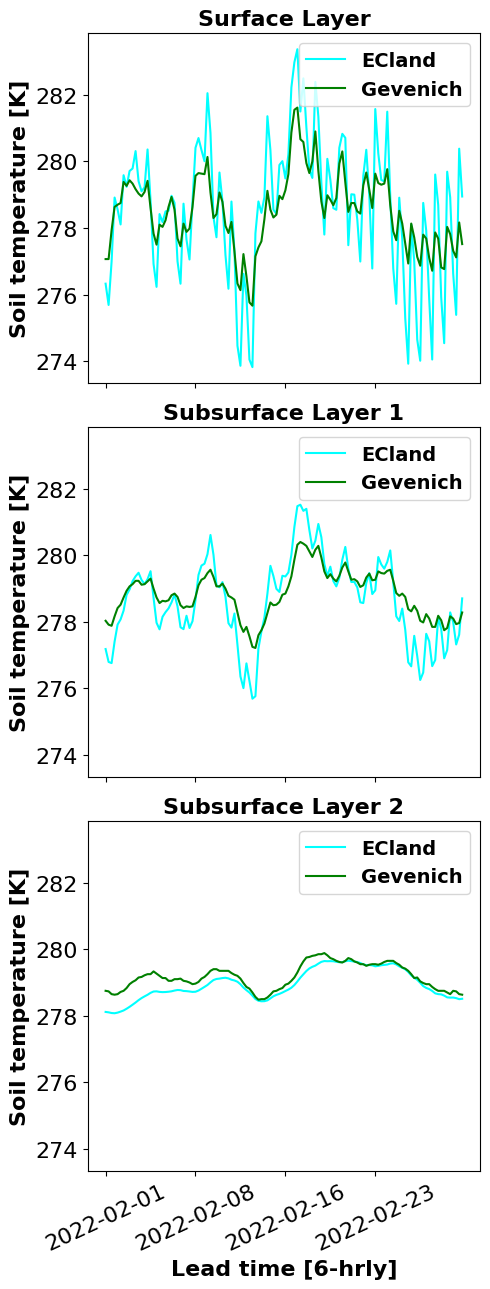

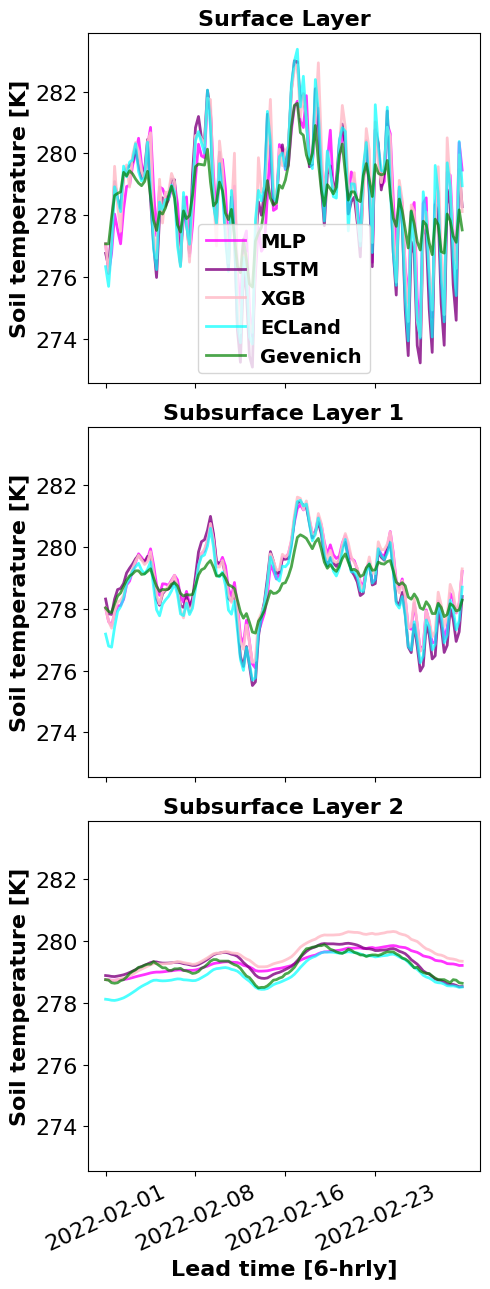

In [4]:
matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_eval'])

GevenichPlots = VisualisationModule(network = network,
                                    station = station,
                                    variable = variable,
                                    maximum_leadtime=maximum_leadtime,
                                    doy_vector = Gevenich.doy_vector,
                                    evaluation = "poi", # ens
                                    path_to_plots=path_to_plots)

GevenichPlots.plot_station_data(dynamic_features_dict['mlp'][:maximum_leadtime], station_data[:maximum_leadtime], 
                                matching_indices= matching_indices)
GevenichPlots.plot_station_data_and_forecast(dynamic_features_dict, dynamic_features_prediction_dict, station_data,
                                matching_indices= matching_indices)

## Evaluate forecast with relative skill

Then we evaluate both ECLand and AIland forecast:
1) Directly against the station data: $D(y_{ai}, y)$ and $D(y_{ec}, y)$
2) Then both against the observed climatology: $D(y_{ai}, y) / D(y_c, y)$ and $D(y_{ec}, y) / D(y_c, y)$

Dependent on what we want to report, we look at the ensemble scores over time, or at the spatially aggregated scores. D can here be the MSE, such that with 2) we compute the MSESS. It could also be the ACC.

In [5]:
def get_daily_forecasts(data):    
    return data[0::4], data[1::4] , data[2::4], data[3::4]

fc_numerical = dynamic_features_dict['mlp']
fc_emulators = dynamic_features_prediction_dict

station_data_1, station_data_2, station_data_3, station_data_4 = get_daily_forecasts(station_data)
fc_numerical_1, fc_numerical_2, fc_numerical_3, fc_numerical_4 = get_daily_forecasts(dynamic_features_dict['mlp'])

fc_emulators_1 = {}
fc_emulators_2 = {}
fc_emulators_3 = {}
fc_emulators_4 = {}

for mod, fc in dynamic_features_prediction_dict.items():

    output1, output2, output3, output4 = get_daily_forecasts(fc)

    fc_emulators_1[mod] = output1
    fc_emulators_2[mod] = output2
    fc_emulators_3[mod] = output3
    fc_emulators_4[mod] = output4

In [6]:
matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_eval'])

layers = {}
for layer in [0,1,2]:
    EvaluateModel = EnsembleEvaluation(score =  score,
                                        layer_index = layer,
                                        variable_indices = matching_indices,
                                        maximum_evaluation_time = maximum_leadtime)

    EvaluateModel.set_samples(observations=station_data,
                                fc_numerical=fc_numerical,
                                fc_emulator=fc_emulators)
    EvaluateModel.subset_samples()
    numerical_score = EvaluateModel.evaluate_numerical()
    ensemble_score = EvaluateModel.evaluate_emulator()
    ensemble_skill = EvaluateModel.get_skill_score()

    scores = {}
    scores_dispersion = {}
    skill_scores = {}
    scores["ECLand"] = numerical_score
    scores["Emulators"] = ensemble_score[0]
    scores_dispersion["Emulators"] = ensemble_score[1]
    skill_scores["Emulators"] = ensemble_skill

    layers[f"layer{layer}"] = {}
    layers[f"layer{layer}"]["scores"] = scores
    layers[f"layer{layer}"]["scores_dispersion"] = scores_dispersion
    layers[f"layer{layer}"]["skill_scores"] = skill_scores

Evaluation with MAE
Shape of subset fc_emulator:  (3, 120, 1)
Shape of subset observations:  torch.Size([120, 1])
Shape of subset fc_numerical:  torch.Size([120, 1])
Evaluation with MAE
Shape of subset fc_emulator:  (3, 120, 1)
Shape of subset observations:  torch.Size([120, 1])
Shape of subset fc_numerical:  torch.Size([120, 1])
Evaluation with MAE
Shape of subset fc_emulator:  (3, 120, 1)
Shape of subset observations:  torch.Size([120, 1])
Shape of subset fc_numerical:  torch.Size([120, 1])


/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/evaluation_module.py:161: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  mae_dispersion = abs(np.subtract(x_preds, x_ref)).std()


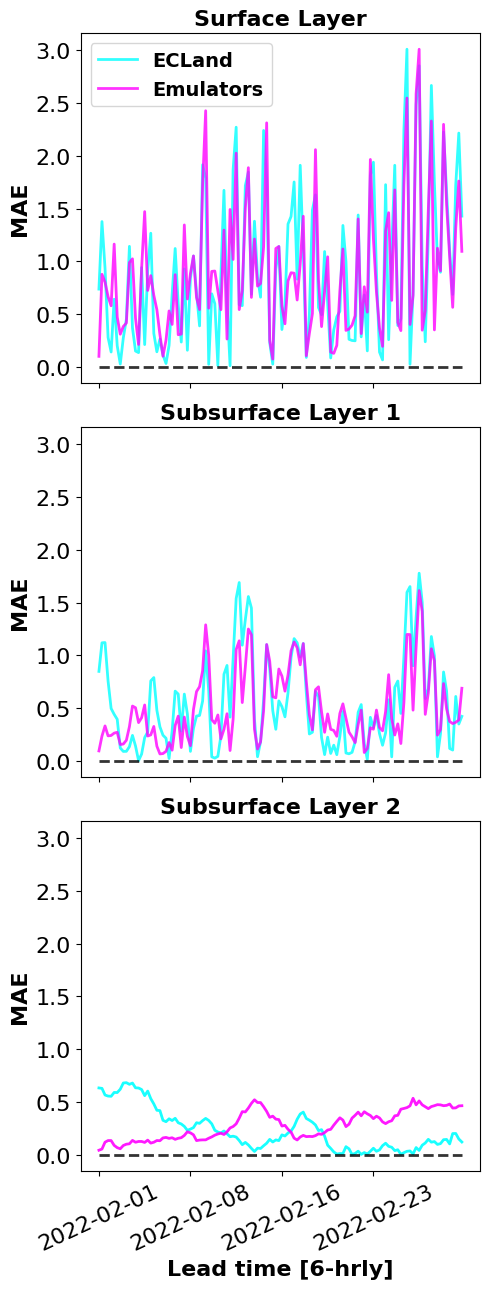

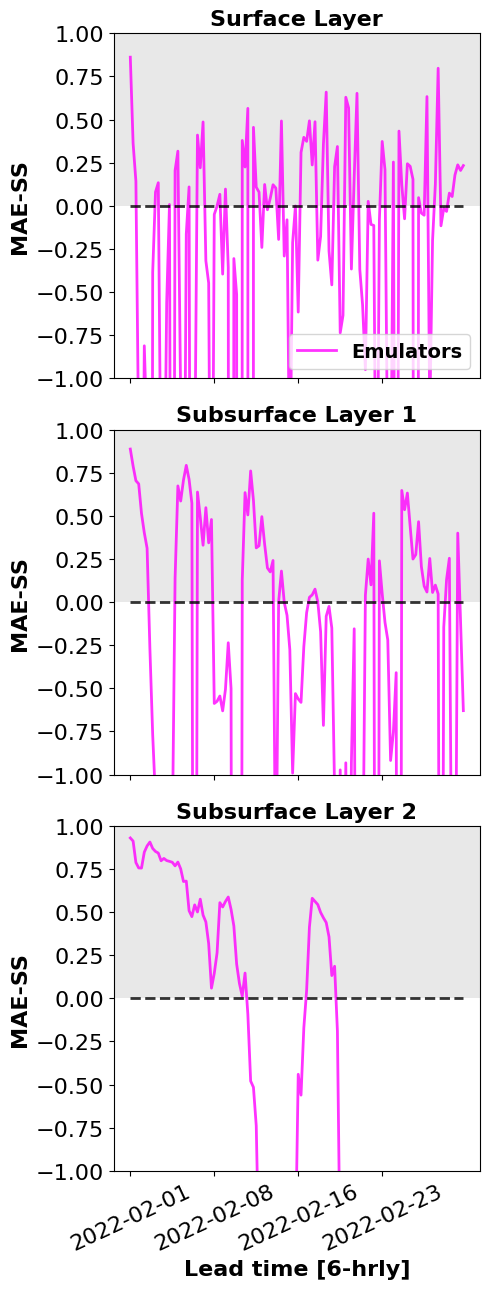

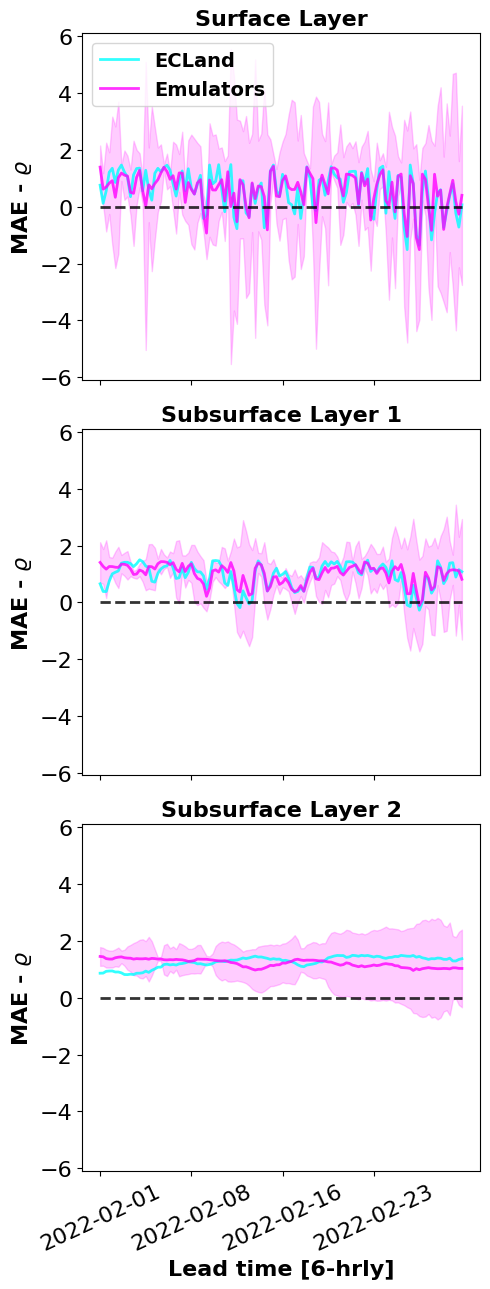

In [7]:
EnsemblePlots = VisualisationModule(network = network,
                                    station = station,
                                    variable = variable,
                                    maximum_leadtime=maximum_leadtime,
                                    doy_vector = Gevenich.doy_vector,
                                    evaluation = "ens", # ens
                                    path_to_plots=path_to_plots)

EnsemblePlots.plot_scores(layers['layer0']['scores'], layers['layer1']['scores'], layers['layer2']['scores'],
                          score = "MAE", log_y=False)
EnsemblePlots.plot_skill_scores(layers['layer0']['skill_scores'], layers['layer1']['skill_scores'], layers['layer2']['skill_scores'],
                          score = "MAE", log_y=False, sharey = False, invert=True)
EnsemblePlots.plot_horizons(layers['layer0']['scores'], layers['layer1']['scores'], layers['layer2']['scores'],
                          score = "MAE", threshold = tolerance, 
                          scores_l1_std = layers['layer0']['scores_dispersion'], 
                          scores_l2_std = layers['layer1']['scores_dispersion'], 
                          scores_l3_std = layers['layer2']['scores_dispersion'],
                          hod=None, log_y=False)

In [8]:
def evaluate(observations, 
             fc_numerical, 
             fc_emulators,
             score, 
             maximum_leadtime):
    
    layers = {}
    for layer in [0,1,2]:
        EvaluateModel = PointEvaluation(score =  score,
                                    layer_index = layer,
                                    variable_indices = matching_indices,
                                    maximum_evaluation_time = maximum_leadtime)
        scores = {}
        scores_dispersion = {}
        skill_scores = {}
        for mod, fc_emulator in fc_emulators.items():

            EvaluateModel.set_samples(observations=observations,
                                    fc_numerical=fc_numerical,
                                    fc_emulator=fc_emulator)
            EvaluateModel.subset_samples()
            scores["ecland"] = EvaluateModel.evaluate_numerical()
            emulator_score = EvaluateModel.evaluate_emulator()
            skill_score = EvaluateModel.get_skill_score()

            scores["ECLand"] = numerical_score
            scores[mod] = emulator_score[0]
            scores_dispersion[mod] = emulator_score[1]
            skill_scores[mod] = skill_score
            
        layers[f"layer{layer}"] = {}
        layers[f"layer{layer}"]["scores"] = scores
        layers[f"layer{layer}"]["skill_scores"] = skill_scores

    return layers

layers = evaluate(observations=station_data,
                  fc_numerical=fc_numerical,
                  fc_emulators=fc_emulators,
                  score=score,
                  maximum_leadtime=maximum_leadtime)

layers_h1 = evaluate(observations=station_data_1,
                  fc_numerical=fc_numerical_1,
                  fc_emulators=fc_emulators_1,
                  score=score,
                  maximum_leadtime=maximum_leadtime)

layers_h2 = evaluate(observations=station_data_2,
                  fc_numerical=fc_numerical_2,
                  fc_emulators=fc_emulators_2,
                  score=score,
                  maximum_leadtime=maximum_leadtime)
layers_h3 = evaluate(observations=station_data_3,
                  fc_numerical=fc_numerical_3,
                  fc_emulators=fc_emulators_3,
                  score=score,
                  maximum_leadtime=maximum_leadtime)

Evaluation with MAE
Shape of subset:  torch.Size([120, 1])
Shape of subset:  torch.Size([120, 1])
Shape of subset:  (120, 1)
Evaluation with MAE
Shape of subset:  torch.Size([120, 1])
Shape of subset:  torch.Size([120, 1])
Shape of subset:  (120, 1)
Evaluation with MAE
Shape of subset:  torch.Size([120, 1])
Shape of subset:  torch.Size([120, 1])
Shape of subset:  (120, 1)
Evaluation with MAE
Shape of subset:  torch.Size([120, 1])
Shape of subset:  torch.Size([120, 1])
Shape of subset:  (120, 1)
Evaluation with MAE
Shape of subset:  torch.Size([120, 1])
Shape of subset:  torch.Size([120, 1])
Shape of subset:  (120, 1)
Evaluation with MAE
Shape of subset:  torch.Size([120, 1])
Shape of subset:  torch.Size([120, 1])
Shape of subset:  (120, 1)
Evaluation with MAE
Shape of subset:  torch.Size([120, 1])
Shape of subset:  torch.Size([120, 1])
Shape of subset:  (120, 1)
Evaluation with MAE
Shape of subset:  torch.Size([120, 1])
Shape of subset:  torch.Size([120, 1])
Shape of subset:  (120, 1)


ValueError: x and y must have same first dimension, but have shapes (120,) and (1,)

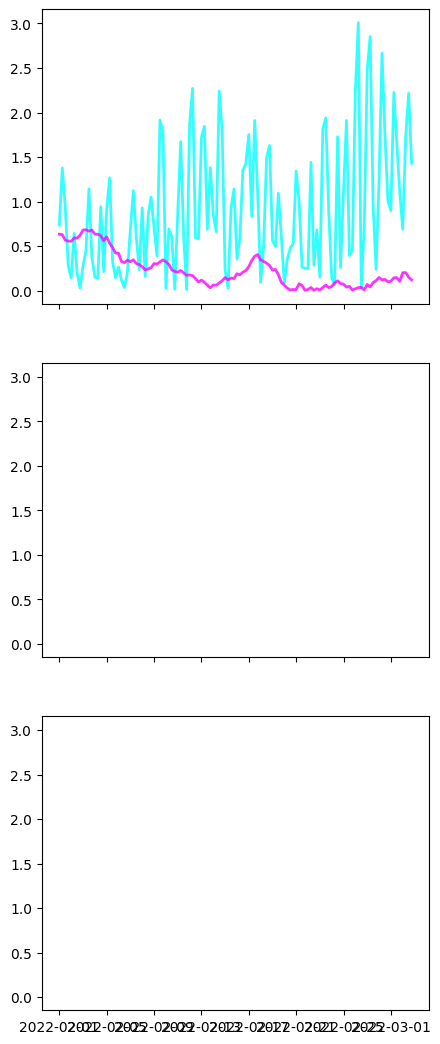

In [9]:
GevenichPlots.plot_scores(layers['layer0']['scores'], layers['layer1']['scores'], layers['layer2']['scores'],
                          score = "MAE", log_y=False)
GevenichPlots.plot_skill_scores(layers['layer0']['skill_scores'], layers['layer1']['skill_scores'], layers['layer2']['skill_scores'],
                          score = "MAE", log_y=False)

GevenichPlots.plot_scores(layers_h1['layer0']['scores'], layers_h1['layer1']['scores'], layers_h1['layer2']['scores'],
                          score = "MAE",hod=1, log_y=False)
GevenichPlots.plot_skill_scores(layers_h1['layer0']['skill_scores'], layers_h1['layer1']['skill_scores'], layers_h1['layer2']['skill_scores'],
                          score = "MAE",hod=1, log_y=False)

GevenichPlots.plot_scores(layers_h3['layer0']['scores'], layers_h3['layer1']['scores'], layers_h3['layer2']['scores'],
                          score = "MAE",hod=3, log_y=False)
GevenichPlots.plot_skill_scores(layers_h3['layer0']['skill_scores'], layers_h3['layer1']['skill_scores'], layers_h3['layer2']['skill_scores'],
                          score = "MAE",hod=3, log_y=False)

GevenichPlots.plot_horizons(layers['layer0']['scores'], layers['layer1']['scores'], layers['layer2']['scores'],
                          score = "MAE", threshold = tolerance, hod=None, log_y=False)
GevenichPlots.plot_horizons(layers_h1['layer0']['scores'], layers_h1['layer1']['scores'], layers_h1['layer2']['scores'],
                          score = "MAE", threshold = tolerance, hod=1, log_y=False)
GevenichPlots.plot_horizons(layers_h3['layer0']['scores'], layers_h3['layer1']['scores'], layers_h3['layer2']['scores'],
                          score = "MAE", threshold = tolerance, hod=3, log_y=False)

## Ensemble forecast with initial state perturbation

The following steps are so far applicable only with the MLP. Here, we slightly perturb model forecast **at the first predicted time step after initialisation**, by a magnitude defined by sigma. This timestep is currently $t_0$ for the LSTM which estimates initial conditions from the lookback, but it is $t_1$ for the MLP and XGB that are initialised with observations at $t_0$. We run multiple deterministic forecasts with this disturbance (defined as ensemble here).

In [ ]:
def perturb_initial_state(initial_state, perturbation_factor = 0.01):
    random_perturbation = torch.rand(initial_state.size()) * 2 - 1  # random values between -1 and 1
    return initial_state * (1 + perturbation_factor * random_perturbation)

def create_perturbation_ensemble(initial_state, size = 50):
    torch.manual_seed(42)
    perturbation_ensemble = [perturb_initial_state(initial_state) for i in range(size)]
    return perturbation_ensemble


: 

In [ ]:
dynamic_features_ensemble = {}
dynamic_features_prediction_ensemble = {}

for mod in ["mlp", "lstm", "xgb"]:

    if mod == 'mlp':
        print('mlp')
        CONFIG = load_config(config_path = '../../configs/mlp_emulator.yaml')
        HPARS = load_hpars(use_model = '../mlp')
        ForecastModel = ForecastModuleMLP(hpars=HPARS, config=CONFIG)    
    elif mod == 'lstm':
        CONFIG = load_config(config_path = '../../configs/lstm_emulator.yaml')
        HPARS = load_hpars(use_model = '../lstm')
        ForecastModel = ForecastModuleLSTM(hpars=HPARS, config=CONFIG)
    elif mod == 'xgb':
        CONFIG = load_config(config_path = '../../configs/xgb_emulator.yaml')
        HPARS = None
        ForecastModel = ForecastModuleXGB(hpars=HPARS, config=CONFIG)

    CONFIG['x_slice_indices'] = closest_grid_cell # adjust the index of the grid cell in the config file before initialising the models

    dataset = ForecastModel.initialise_dataset()
    model = ForecastModel.load_model()
    x_static, x_met, y_prog, y_prog_initial_state = ForecastModel.load_test_data(dataset)  
    print("INITIAL STATE SHAPE:", y_prog_initial_state.shape)

    station_data = Gevenich.slice_station_data(lookback=CONFIG["lookback"],
                                    t_0=EX_CONFIG['initial_time'])
    matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_eval'])
    y_prog_initial_state[..., matching_indices] = station_data[0]
    
    perturbed_ensemble = create_perturbation_ensemble(y_prog_initial_state)

    ensemble_prediction = []
    for i in range(len(perturbed_ensemble)):
        matching_indices = Gevenich.match_indices(dataset=dataset,
                                              target_variables=EX_CONFIG['targets_prog'])
        initial_vector =  Gevenich.transform_station_data(station_data = perturbed_ensemble[i])

        dynamic_features, dynamic_features_prediction = ForecastModel.run_forecast(initial_conditions=initial_vector, 
                                                                                initial_conditions_perturbation=None,
                                                                                predictions_perturbation = None)
        dynamic_features, dynamic_features_prediction = ForecastModel.backtransformation()
        ensemble_prediction.append(dynamic_features_prediction)

    dynamic_features_ensemble[mod] = dynamic_features
    dynamic_features_prediction_ensemble[mod] = ensemble_prediction

: 

In [ ]:
dynamic_features_prediction_ensemble['mlp'][0].shape
dynamic_features_prediction_ensemble['lstm'][0].shape
dynamic_features_prediction_ensemble['xgb'][0].shape


: 

In [ ]:
ensemble_dict = dynamic_features_prediction_ensemble
for key, ensemble_prediction in ensemble_dict.items():
    ensemble_dict[key] = np.stack(ensemble_prediction)

: 

In [ ]:
size = EX_CONFIG['ensemble_size']

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True) 

colors = ["magenta", "purple", "pink"]
j=0
for key, ensemble_prediction in ensemble_dict.items():
    for i in range(size):
        label = key if i == 0 else None
        ax[0].plot(ensemble_prediction[i, :,:,3], color=colors[j], label=label, alpha = 0.5)
    j+=1
ax[0].plot(dynamic_features_ensemble['lstm'][:,:,3], color="darkblue", label="ecland", alpha = 0.9)
ax[0].plot(station_data[:,:,0], color="green", label="station data", alpha = 0.9)
ax[0].set_title("Layer 1")
ax[0].legend()

j=0
for key, ensemble_prediction in ensemble_dict.items():
    for i in range(size):
        label = key if i == 0 else None
        ax[1].plot(ensemble_prediction[i, :,:,4], color=colors[j], label=label, alpha = 0.5)
    j+=1
ax[1].plot(dynamic_features_ensemble['lstm'][:,:,4], color="darkblue", label="ecland", alpha = 0.9)
ax[1].plot(station_data[:,:,1], color="green", label="station data", alpha = 0.9)
ax[1].set_title("Layer 2")
ax[1].legend()

j=0
for key, ensemble_prediction in ensemble_dict.items():
    for i in range(size):
        label = key if i == 0 else None
        ax[2].plot(ensemble_prediction[i, :,:,5], color=colors[j], label=label, alpha = 0.5)
    j+=1
ax[2].plot(dynamic_features_ensemble['lstm'][:,:,5], color="darkblue", label="ecland", alpha = 0.9)
ax[2].plot(station_data[:,:,2], color="green", label="station data", alpha = 0.9) 
ax[2].set_title("Layer 3")
ax[2].legend()

plt.tight_layout()
fig_path = os.path.join(path_to_plots, f'{network.split('_')[1]}_{station}_{2022}_{variable}_ensemble_forecast.pdf')
plt.savefig(fig_path)
plt.show()


: 